In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import tensorflow as tf
from sopt.examples.utils import NearFieldPtychographySimulation
from sopt.examples.tensorflow.near_field_ptychography.tfPtycho import CurveballPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
%load_ext autoreload
%autoreload 2

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


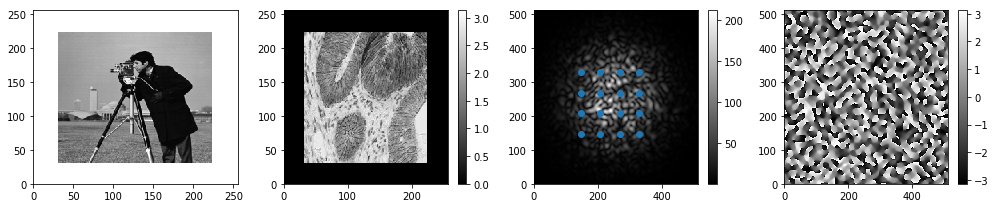

In [3]:
ptsim = NearFieldPtychographySimulation(positions_step_npix=60, probe_args={'photons_flux':1e3})

obj_center_positions = ptsim._positions + ptsim._obj_params.padded_npix // 2

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
axs[2].scatter(x=obj_center_positions.T[1], y=obj_center_positions.T[0])
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax1, ax=axs[1])
plt.colorbar(cax2, ax=axs[2])
plt.colorbar(cax3, ax=axs[3])
plt.tight_layout()
plt.show()

## Curveball - reconstructing the object only

In [8]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=2)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [9]:
pr_cb.run(improvement_threshold=1e-4)
pr_cb.data.tail(n=1)

10  2302494 0.3781176       50 810577.6 955842.8
20 846605.2 0.2729968       50 282221.4 306343.4
30   627430 0.2160735       50 154201.3   160974
40   538032 0.1733167       60 113554.9 116405.6
50 509134.9 0.1430788       75 95102.52 96383.04
60 499165.9 0.1200019       90 89163.34 89233.86
70 493183.4 0.09545751      105 87677.88 88196.22
80 489071.5 0.07395505      120 81483.52 82064.52
90   485994 0.07196641      135 77989.53 78160.97
100 484147.4 0.07928784      150 77224.58 77302.06
110 482945.7 0.0810219      165 76195.95 76313.92
120 481933.1 0.0817871      180 75556.35 75592.16
130 481236.2 0.08315857      195 74952.81 75037.78
140 480725.2 0.08164302      210 74442.44  74462.5
150 480261.4 0.07569175      225 74194.41 74242.89
160 479814.4 0.06479417      240  73604.1  73662.2
170   479374 0.05094717    253.5  73330.7  73336.6
180 478955.8 0.04295156    253.5 73342.76 73328.78
190 478613.7 0.04488111      285 73282.73  73295.2
200 478327.7 0.05189052      300 73032.16 73071.

,loss,epoch,obj_error,probe_error,validation_loss,patience
567,476402.5,567.0,0.023378,NaN,71847.453125,567.0


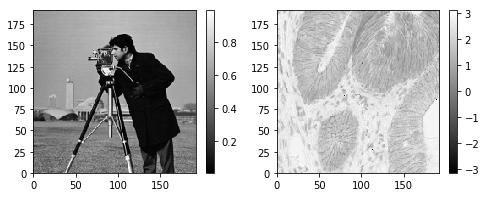

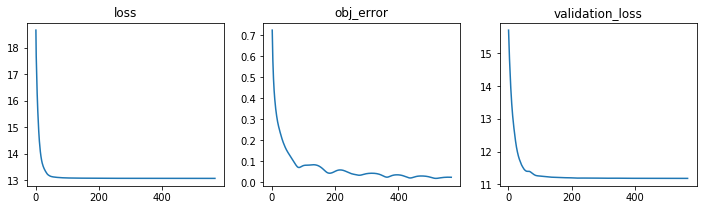

In [10]:
pr_cb.genPlotsRecons()
pr_cb.genPlotMetrics()

In [11]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
6.91e+09
3.92e+12
9.33e+08	 1.19e+08
total flops 3.32e+12


## With batching

In [12]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, probe_recons=False, batch_size=5, validation_ndiffs=2)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [13]:
pr_cb.run(improvement_threshold=1e-4)
pr_cb.data.tail(n=1)

10 322102.7 0.2751843       50 130654.3   145264
20 224177.9 0.2164373       50 82139.69 83746.04
30 196691.8 0.1931469       50 76818.19 77379.41
40 187702.9 0.1768263       60 74175.66 74258.55
50 188770.9 0.1657803       75 73400.87 73420.66
60 177856.9 0.1544735       87 72941.88 72648.45
70 178064.2 0.1464845      105 72135.29 72184.83
80 179103.2 0.1399936      120 72026.41 72097.91
90 179552.1 0.1336014    133.5 71926.05 71784.94
100 177488.7 0.1282686      144 71866.67 71718.72
110 179347.2 0.1228012      162 71755.91 71671.78
120 176461.3 0.1169507    175.5 71638.12  71631.5
130 178200.6 0.1127821      195 71552.03 71584.31
140   173532 0.1079459      198 71586.98 71462.11
150 175447.5 0.1033292      219 71403.05  71367.5
160 174460.3 0.09942373      228 71401.74 71336.49
170   175145 0.09590331      228 71376.88  71332.3
180   176987 0.09274177      264 71430.16 71230.86
190 174944.5 0.08933605      264  71409.2 71230.86
200 174370.1 0.08608376      264 71284.52 71230.86
210 

,loss,epoch,obj_error,probe_error,validation_loss,patience
2370,172784.125,1185.0,0.012393,NaN,70978.578125,1185.0


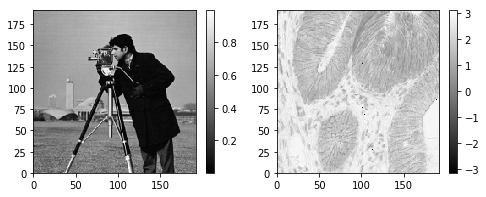

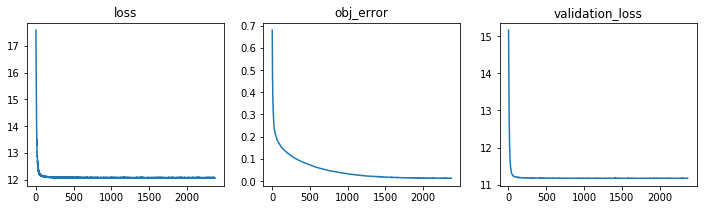

In [14]:
pr_cb.genPlotsRecons()
pr_cb.genPlotMetrics()

In [15]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(f'{flops_cb_and_fwd:4.3g}')

total_flops = pr_cb.data.index[-1] * flops_cb_and_fwd
print(f'{total_flops:4.3g}')

graph_def = pr_cb.graph.as_graph_def()
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr_cb.graph, nodes_validation)

print(f'{flops_damping:4.3g}\t {flops_validation:4.3g}')
total_flops_actual = (flops_cb_and_fwd - flops_damping - flops_validation) * pr_cb.data.index[-1]
print(f'total flops {total_flops_actual:4.3g}')

2.43e+09
5.75e+12
3.14e+08	 1.19e+08
total flops 4.73e+12
